# Understanding genomic sequence attribution scores

## Summary

To understand the decision process of genomic sequence-to-function models, various explainable AI algorithms have been proposed. These methods determine the importance of each nucleotide in a given input sequence to the model’s predictions, and enable discovery of cis regulatory motif grammar for gene regulation. Although widely used to analyze genomic experiments, the underlying theory and connection between these methods is often not well defined. A lot of practitioners use various methods interchangeably and process them intuitively to be in line with their expectations by matching identified motifs to databases of known factors. Moreover, reviewers often demand proof that alternative methods produce similar results from comparisons of simple heuristics or a few random examples. Here we discuss a unifying concept of the most common feature importance scores used to analyze genomic sequences. Genomic feature attributions are corrected across bases in a position specific way. The presented concepts enable comparison of different methods through a consistent correction. First, we use Taylor approximation to connect the gradients to the widely used method of in silico saturation mutagenesis. Then we use the definition of the field-specific “hypothetical importance scores”, a transformation to the local attributions, to show how every commonly used method can be transformed to represent hypothetical scores. This unifying view explains similarities and differences between commonly used feature importance scores for identification of sequence motifs and puts it in a clearly defined mathematical frame to compare them. 

## Feature importance scores 
    
Sequence-to-function models have become the preferred tool to analyze the relationship between genomic sequence and genome-wide experimental measurements such as chromatin accessibility [[1]](#1)[[2]](#2), gene expression 3–5, 3D chromatin conformation 6–8, and other molecular data modalities 9–11. These models usually consist of some sort of a convolutional neural network that operates on a one-hot encoded sequence to predict the measured phenotype. To better understand the models' decision processes, and extract the learnt gene regulatory language, various feature attribution methods can be applied to these Deep Learning models 12–14. For genomic sequence-to-function models, these methods estimate the importance of each possible nucleotide within an input sequence to the model's prediction. It is hoped that when applied to increasingly accurate sequence-based deep learning models, these methods can aid in solving for a comprehensive cis regulatory grammar and replace laborious and expensive in vivo experiments to identify regulatory sequences across the genome 4,9,15. 

Feature attribution methods can be classified into ***perturbation***- (or *sampling*-) and ***backpropagation***-based algorithms 16. Both classes of methods approximate the non-linear neural network function $f(s)$ around the sequence of interest $s_0$ with a linear model within the regime of $\Delta s$. The linear model assigns a single multiplier $m_{s_0}$ to every input feature, from which one can attribute importances to the individual input features to the model’s predictions.

\begin{align}
f(s_0+\Delta s) \approx f(s_0) + m_{s_0} \cdot \Delta s
\tag{1}
\end{align}
    
For example, to approximate the value of a complex function $f$, the over 300 year old Taylor’s approximation linearly decomposes the function value $f(s)$ around the nearby position $s_0$, with the derivative of the function $\frac{df}{ds_0}$ at $s_0$ multiplied by the difference between the position of interest $s_0-s = \Delta s$.

\begin{align}
f(s_0+\Delta s) \approx f(s_0) + \frac{df}{ds_0} \cdot \Delta s
\tag{2}
\end{align}
    
Taylor’s approximation represents a linearr backpropagation-based approximation in the infinitely small regime around the point $s_0$ with the multiplier $m_{s_0}$ represented by the gradient $\frac{df}{ds_0}$ at $s_0$. To interpret these local linear approximations of the model, people derive either ***local*** or ***global*** ***importance scores*** from them 17. Local importance scores are simply given by the coefficients or multipliers of the linear approximation of the model. They determine how important an input feature is locally around the sequences. Global importance scores are given by the linear coefficients multiplied with the difference between the investigated sequence and a ‘neutral’ reference sequence. Global scores account for different scales of non-standardized features. 

\begin{align}
a_{global}= m_{s_0} \cdot \Delta s
\tag{3}
\end{align}

\begin{align}
a_{local}= m_{s_0}
\tag{4}
\end{align}


In [1]:
import numpy as np
import torch
import torch.nn as nn
import time
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

from tism.models import Beluga
from tism.utils import plot_attribution, ism, deepliftshap
from tism.torch_grad import correct_multipliers, takegrad

from tangermeme.utils import random_one_hot
from tangermeme.ersatz import substitute

# Download from https://zenodo.org/record/3402406/files/deepsea.beluga.pth
parameters = '../data/deepsea.beluga.pth'
model = Beluga()
model.load_state_dict(torch.load(parameters))
model.eval()
    
N=1 # number of sequences
b=4 # number of bases
input_length = 2000 
    
x = random_one_hot((N, b, input_length), random_state = 1).type(torch.float32)
x = substitute(x, "CTCAGTGATG")
x = x.detach().cpu().numpy()
    
track = 267 # is the JUN TF CHIP-seq track
vis_seq = 0

Local attribution scores computed, aka gradients, in 0.332s of shape (1, 1, 4, 2000)
Global attribution scores computed, aka gradient times input, in 0.339s of shape (1, 1, 4, 2000)


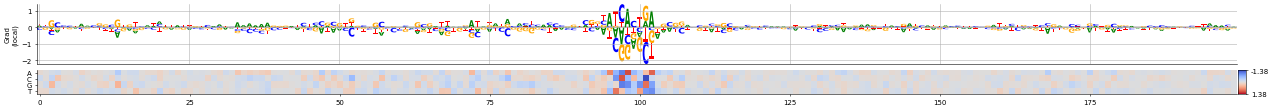

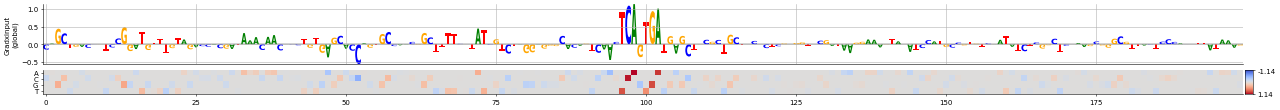

In [3]:
# compute gradient (local attributions)
t1 = time.time()
grad_local = takegrad(x, model, tracks = track, output = 'local', device = None, baseline = None)
t2 = time.time()
print("Local attribution scores computed, aka gradients, in", '{}s'.format(round(t2-t1,3)), 'of shape', np.shape(grad_local))
    
grad_local0 = grad_local[vis_seq,0][...,900:1100]
fig_local = plot_attribution(grad_local0, heatmap = grad_local0, ylabel = 'Grad\n(local)')
    
# compute gradient times input ( global attributions to 0 reference)
t1 = time.time()
grad_global = takegrad(x, model, tracks = track, output = 'global', device = None, baseline = np.zeros(b))
t2 = time.time()
print("Global attribution scores computed, aka gradient times input, in", '{}s'.format(round(t2-t1,3)), 'of shape', np.shape(grad_global))
    
grad_global0 = grad_global[vis_seq,0][...,900:1100]
fig_global = plot_attribution(grad_global0, heatmap = grad_global0, ylabel = 'Gradxinput\n(global)')




Other backpropagation based methods approximate the linear function in a larger regime from sequence of interest to a baseline sequence $s_b$. The baseline is often defined as a sequence with neutral prediction, or more stringent as the “closest sequence” to the sequence with neutral prediction. These methods guarantee completeness, also known as efficiency. Completeness guarantees that the sum of all global attributions will be equal to the difference of the function between the baseline and the sequence of interest, a constraint of the feature attribution method that can be useful for some situations.

\begin{align} 
\sum_{l,i}^{L,4} a_{global}= \Delta f=f(s_b)-f(s_0)
\tag{5}
\end{align}

A comprehensible strategy to create an approximation is through sampling-based methods. These methods sample a sufficient number of data points between $s$ and $s_0$ to fit a generalized linear model to them. The choice of the sampling and the choice of the generalized linear model define the resulting multipliers and determine their interpretations. Sampling based methods can also be used to explicitly fit second, or even higher order effects from sufficient numbers of sampled data points 18. On the other hand, sampling based methods suffer from the large computational cost that is required for generating these large numbers of data points. Perturbation-based methods represent a special case of sampling-based methods, which usually reduce the sampling cost to a minimum number of one sample per feature. By disturbing only a single feature at the time while leaving all others as they are, one can directly derive the varied features' multiplier from the difference of models predictions to the original. 

In computer vision, these perturbations are simply performed by setting pixels to zero. However, for genomic sequence based models which use one-hot encoded sequences of length L and width 4 (A,C,G,T bases), these perturbations are motivated by wet lab experiments, in which one base is exchanged for another. These so-called ***in silico mutagenesis (ISM)*** experiments, set the current base to zero but also add a one to another base at the same position in the one-hot encoding 15. It can be intuitively compared to performing  in vivo saturation mutagenesis experiments 16. The differences between the predictions of these variant sequences and the prediction from the “reference” (initial) sequence is then used to define the impact or the importance of the reference base and each alternative bases along the sequence. 

## Taylor approximation links gradients to ISM values

Taylor directly links ISM to the linear approximation from the models' gradients. The gradient $\frac{df}{ds_0}$ can also be represented as the finite difference from the reference $s_0$ to a sequence with a single nucleotide substitution from $b_0$ to $b_1$ at position $l$, denoted by  $s_0(l,b_0 \rightarrow b_1)$.

\begin{align}
f(s) \approx f(s_0)+ \frac {\delta f(s_0)}{\delta s} \cdot \Delta s = f(s_0)+\frac{f(s_0(l,b_0 \rightarrow b_1))-f(s_0)} {s_0(l,b_0 \rightarrow b_1)-s_0} \cdot \Delta s		
\tag{6}
\end{align}

In the case where the finite distance $\delta s$ to approximate the gradient is equal to the distance from the reference sequence $\Delta s$, the numerator and denominator cancel each other out and we are left with the ISM value given by Equation (3).

\begin{align}
= f(s_0)+\frac{f(s_0(l,b_0 \rightarrow b_1))-f(s_0)} {\cancel{s_0(l,b_0 \rightarrow b_1)-s_0}} \cdot \cancel{(s_0(l,b_0 \rightarrow b_1)-s_0)}\\
=f(s_0)+f(s_0(l,b_0 \rightarrow b_1))-f(s_0)=f(s_0)+ISM(s_0,l,b_1)
\tag{7}
\end{align}
    
Using this relationship enables us to approximate time consuming ISM values from the models' gradient.

\begin{align}
f(s_0)+ISM(s_0,l,b_1) = f(s_0)+\frac{df}{ds_0} \cdot s_0(l,b_0, b_1)-\frac{df}{ds_0} \cdot s_0 = f(s_0) + TISM(s_0,l,b_1)
\tag{8}
\end{align}

where TISM denotes the first-order Taylor approximation to ISM. Applying this to a one-hot encoded input in which the reference base $b_0$ a position $l$ is replaced (set $b_0$ from 1 to 0) by an alternative base $b_1$ (set $b_1$ from 0 to 1), we can see that the ISM at $l$, $b_1$ is equal to the gradient with respect to the reference sequence $s_0$ at base $l$,$b_1$ minus the gradient at base $l$,$b_0$. 

\begin{align}
ISM(s_0,l,b_1) = \frac{df^{(l,b_1)}}{ds_0}- \frac{df^{(l,b_0)}}{ds_0}=TISM(s_0,l,b_1)
\tag{9}
\end{align}

Using this relationship enables us to quickly approximate the per nucleotide ISM values from the gradient of the input sequence with a single forward pass through the model. 

In practice, ISM values are used in two ways: (1) as a per-nucleotide value that indicates how much the prediction changes if the reference base is replaced by the specific variant; (2) as ***attribution maps*** which indicate how important each nucleotide is for a model’s prediction. To generate attribution maps from ISM values, practitioners use different methods. A comprehensible method maps the size of the mean effect from replacing the reference base with one of the three alternatives onto the reference base. This representation is then used to determine motifs, i.e. longer seqlets with subsequent bases with significant attributions.

TISM values computed from gradients in 0.322s of shape (1, 1, 4, 2000)
ISM values would be computed for 2,000bp in 72.708s of shape (1, 1, 4, 2000)
ISM versus TISM
0 0.7974074282772302


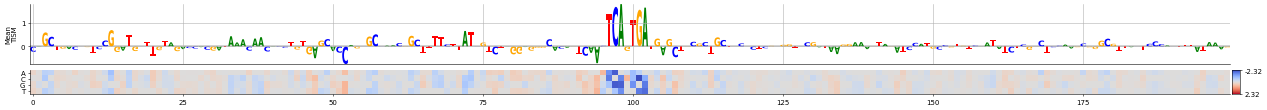

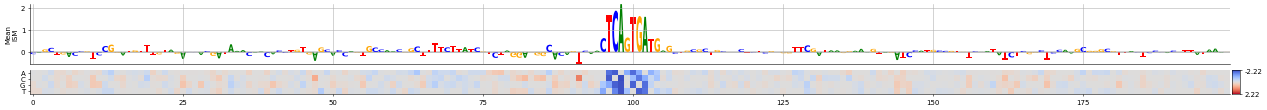

In [6]:
# compute taylor approximated in silico saturation mutagenesis effects.
t1 = time.time()
grad_tism = takegrad(x, model, tracks = track, output = 'tism', device = None, baseline = None)
t2 = time.time()
print("TISM values computed from gradients in", '{}s'.format(round(t2-t1,3)), 'of shape', np.shape(grad_tism))
    
# TISM can be used just like ISM values, for example plotting the mean effect of mutating a base to determine the importance of that base.
tism0 = grad_tism[vis_seq,0]
meaneffect_tism = -np.sum(tism0/3, axis = -2)[None,:] * x[vis_seq]
fig_tism = plot_attribution(meaneffect_tism[...,900:1100], heatmap = tism0[...,900:1100], ylabel = 'Mean\nTISM')
    
# compute ISM effects
t1 = time.time()
ism_array = ism(x, model, tracks = track, start = 900, end = 1100)
t2 = time.time()
print("ISM values would be computed for 2,000bp in", '{}s'.format(round(10*(t2-t1),3)), 'of shape', np.shape(ism_array))
    
ism0 = ism_array[vis_seq,0]
meaneffect_ism = -np.sum(ism0/3, axis = -2)[None,:] * x[vis_seq]
fig_ism = plot_attribution(meaneffect_ism[...,900:1100], heatmap = ism0[...,900:1100], ylabel = 'Mean\nISM')
    
# Compare ISM to TISM
print('ISM versus TISM')
for i in range(np.shape(x)[0]):
    print(i, pearsonr(grad_tism[i,0][...,900:1100].flatten(), ism_array[i,0][...,900:1100].flatten())[0]) #, pearsonr(mean_grad_tism[i,0], mean_grad_ism[i,0])

## Hypothetical attribution scores make different methods comparable

While local and global importance scores are common in image classification, a third attribution score has become more relevant for genomic sequence analysis, the ***“hypothetical attribution score”***. 

>“The hypothetical importance scores are meant to give a sense of what importance would be placed on a different base in the sequence if that base were present. We tend to think of it as an "autocomplete" of the scores, because in cases where you have a partial motif match, the hypothetical importance scores could give you a sense of what a stronger motif match would have looked like.” (https://github.com/kundajelab/tfmodisco/issues/5).
>
This feature is beneficial to extract contribution weight matrices (CWMs) that, similar to position weight matrices (PWMs), not only tell us about the contribution of the feature that is present but also about what would be preferred instead. The hypothetical contributions for a base are created by a transformation of the local attribution scores, which subtracts the sum over all bases of the difference between the baseline and the sequence of interest weighted by their local attributions from the attribution at the base, i.e. the difference between a sequence where the hypothetical base was present and the selected baseline sequence with base-pair probabilities $b(i)$ at base $i$. 

\begin{align}
a_{hypo}(j)= m_{s_0}(j) - \sum_{i}^{A,C,G,T} b(i) \cdot m_{s_0}(i) \quad	; j \in \{A,C,G,T\}
\tag{10}
\end{align}

Hypothetical attributions determine the effect at the entire loci if one would go from the chosen baseline to a sequence with that base at this position. This feature seems to better represent the learned sequence grammar of the model, which is why they have been introduced in TFmodisco [[21]](#21), a widely used software package to extract and cluster sequence motifs from attribution maps.

For gradient-based attributions, we can see that the recently suggested correction by *Majdandzic et al.* [[22]](#21) of the gradient also represents the hypothetical attribution score from a baseline with 0.25 uniform base-pair probability. 

\begin{align}
grad_{corr}(j)=grad(j)- \frac{1}{4} \sum_{i} grad(i) = m_{s_0}(j) - \sum_{i} 0.25 \cdot grad(i) =a_{grad_{hypo-uniform}}(j) 	(11)
\tag{11}
\end{align}

Note, that a recent publication by *Posfani et al. 2024* correctly defined this processing of the attribution scores as *"fixing the gauge"* of the model parameters [[23]](#23). 
>Before the values of model parameters can be meaningfully interpreted, one must remove these degrees of freedom (called “gauge freedoms” in physics) by imposing additional constraints (a process called “fixing the gauge”).
>

Hypothetical attribution scores computed, aka corrected gradients, in 0.301s of shape (1, 1, 4, 2000)


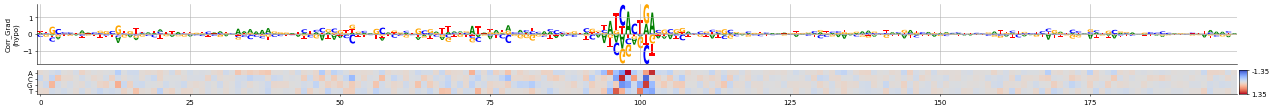

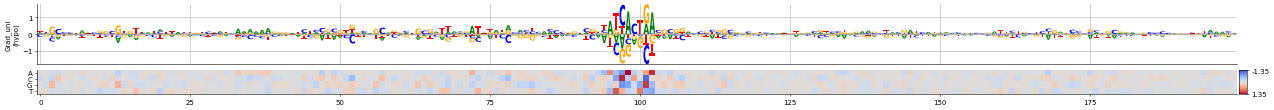

In [4]:
# compute corrected gradients, which can also be referred to as hypothetical attributions with uniform baseline
t1 = time.time()
grad_corrected = takegrad(x, model, tracks =track, output = 'corrected', device = None, baseline = None)
t2 = time.time()
print("Hypothetical attribution scores computed, aka corrected gradients, in", '{}s'.format(round(t2-t1,3)), 'of shape', np.shape(grad_corrected))
    
grad_hypothetical_uniform = takegrad(x, model, tracks = track, output = 'hypothetical', device = None, baseline = np.ones(b)*0.25)
    
# Hypothetical attribution scores to uniform baseline are equivalent to corrected gradients
grad_corrected0 = grad_corrected[vis_seq,0]
fig_corrected = plot_attribution(grad_corrected0[...,900:1100], heatmap = grad_corrected0[...,900:1100], ylabel = 'Corr_Grad\n(hypo)')
grad_hypothetical_uniform0 = grad_hypothetical_uniform[vis_seq,0]
fig_hypothetical = plot_attribution(grad_hypothetical_uniform0[...,900:1100], heatmap = grad_hypothetical_uniform0[...,900:1100], ylabel = 'Grad_uni\n(hypo)')

To visualize and identify sequence motifs from ISM, ISM values at all loci are often centered around the mean effect, so that the effect of the reference base becomes the negative mean of the effects from replacing it with the other four bases. 

\begin{align}
ISM_c(j) = ISM(j)-\sum_{i}^{A,C,G,T} ISM(i)
\tag{12}
\end{align}

Knowing that the ISM value $ISM(j)$ of an alternative base $j$ is the result of removing the reference base $r$ and replacing it with the alternative base $j$, we can also write this procedure in the form of the coefficients of the linear approximation of the model. 

\begin{align}   
ISM(j)= f(s_0(r \rightarrow j))-f(s_o) = m_s \cdot \Delta s
\tag{13}
\end{align}   

Note that  represent the vector product. Since only the two above mentioned procedures are performed during ISM, this vector product simply reduces to:

\begin{align}    
ISM(j) = m_s(j)-m_s(r)	(14)
\tag{14}
\end{align}

With (10) inserted into (8), we can easily determine that indeed the centered ISM values are also representing the hypothetical attributions to a uniform baseline of 0.25. 

\begin{align}
ISM_c(j) =ISM(j)- \sum_{i}^{A,C,G,T} ISM(i) = m_s(j) - sum_{i}^{A,C,G,T} 0.25 \cdot m_s(i) =a_{ISM_{hypo-uniform}}(j)
\tag{15}
\end{align}

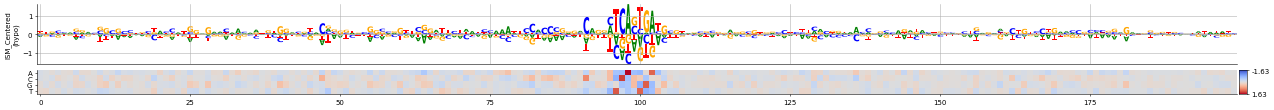

In [7]:
# Hypothetical attributions to uniform baseline are equivalent to centered ISM 
ism_hypothetical = correct_multipliers(ism_array, 'corrected')
ism_hypo0 = ism_hypothetical[vis_seq,0]
fig_ismhyp0 = plot_attribution(ism_hypo0[...,900:1100], heatmap = ism_hypo0[...,900:1100], ylabel = 'ISM_Centered\n(hypo)')

## Summary and discussion
Attribution scores are derived from coefficidents (multipliers) of linear approximations of the non-linear Neural network around the sequence of interest. These local attribution scores are then further processed as global or hypothetical attribution scores. Hypothetical attributions seem to crucial for identifying the regulatory grammar that sequence-to-function models learn. *Posfani et al. 2024* determined that hypothetical attribuions to a uniform baseline can be interpreted as *"zero-sum gauge"*[[23]](#23) of the linear approximation. In concordance with other benchmarks [[21,22]] for motif discovery, the zero-sum gauge seems to be beneficial for motif discovery. 

Here, we tried to provide a comprehesable overview on sequence attributions and their processing to better understand the values that they produce. We hope that it became clear that comparisons between attributions scores should be performed on the same type (i.e. local, global, or hypothetical attribution scores) or same gauge. To do that, practitioners need to have a basic understanding the individual method that they use. However, why transforming multipliers from any linear approximation method to "hypothetical attribution" scores (i.e. the zero-sum gauge) is beneficial for motif identifcation in genomic sequence is still not entirely clear to us, although the definition of hypothetical attributions provides us with some idea on why this could be. 

Attribution scores differ between the process that they use to approximate the linear multipliers around the sequence of interest, and therefore return different multipliers. For example, DeepLift approximates the gradient of non-linear activation functions with the finite difference between the sequence of interest and baseline sequence instead of the gradient from the model's backpropagation. If we return multipliers for DeepLift, we can also transform them to hypothetical attributios and compare them against (T)ISM. 

DeepLift local scores computed in 0.124s of shape (1, 1, 4, 2000)
DeepLift versus Gradient hypothetical
0 0.7105614646764904


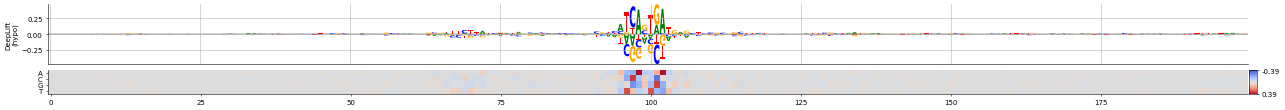

In [8]:
# Let's compare hypothetical attributions from gradients to hypothetical attributions from deeplift

t1 = time.time()
grad_deeplift = deepliftshap(x, model, tracks = track, baseline = torch.ones(4)*0.25)
t2 = time.time()
print("DeepLift local scores computed in", '{}s'.format(round(t2-t1,3)), 'of shape', np.shape(grad_deeplift))
    
# Create hypothetical deeplift scores from local scores 
grad_deeplift_hypothetical = correct_multipliers(grad_deeplift, 'hypotetical', x, np.ones_like(x)*0.25)
grad_deeplift0 = grad_deeplift_hypothetical[vis_seq,0]
fig_deeplift = plot_attribution(grad_deeplift0[...,900:1100], heatmap = grad_deeplift0[...,900:1100], ylabel = 'DeepLift\n(hypo)')
    
# Now let's compare these attributions with each other
# hypothetical scores from grad versus hypothetical scores from deeplift
print('DeepLift versus Gradient hypothetical')
for i in range(np.shape(x)[0]):
    print(i, pearsonr(grad_hypothetical_uniform[i,0].flatten(), grad_deeplift_hypothetical[i,0].flatten())[0])

Note that for interpretation, people usually just plot the attributions of bases that are present in the sequence, since only these can contribute to the model's predictions. However, when we want to summarize what the model prefers or learns, it is value to also look at the hypothetical attributions of all bases and cluster them, as performed by TFmodisco.  

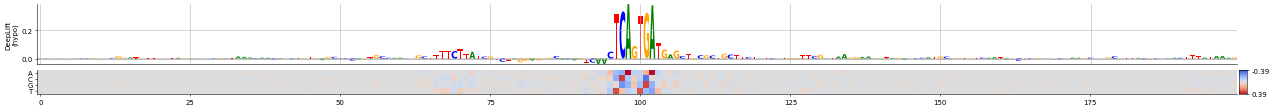

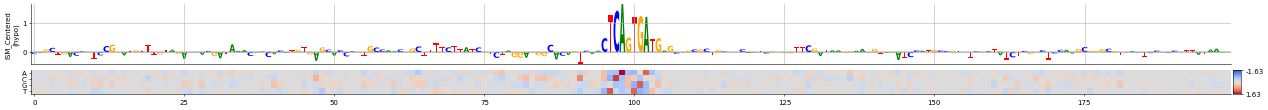

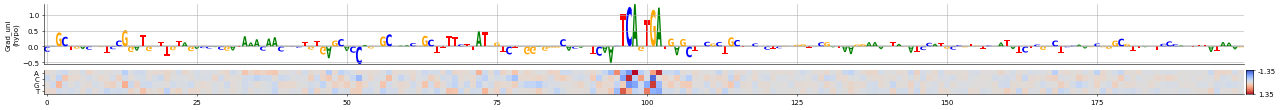

In [10]:
fig_deeplift_ref = plot_attribution(grad_deeplift0[...,900:1100] * x[vis_seq][...,900:1100], heatmap = grad_deeplift0[...,900:1100], ylabel = 'DeepLift\n(hypo)')
fig_ismhyp_ref = plot_attribution(ism_hypo0[...,900:1100]* x[vis_seq][...,900:1100], heatmap = ism_hypo0[...,900:1100], ylabel = 'ISM_Centered\n(hypo)')
fig_gradhyp_ref = plot_attribution(grad_hypothetical_uniform0[...,900:1100]* x[vis_seq][...,900:1100], heatmap = grad_hypothetical_uniform0[...,900:1100], ylabel = 'Grad_uni\n(hypo)')

## References
<a id="1">[1]</a> Kelley, D. R. et al. Sequential regulatory activity prediction across chromosomes with convolutional neural networks. Genome Res. 28, 739–750 (2018).\
<a id="2">[2]</a> Zhou, J. & Troyanskaya, O. G. Predicting effects of noncoding variants with deep learning-based sequence model. Nat. Methods 12, 931–934 (2015).\
<a id="3">[3]</a> Zhou, J. et al. Deep learning sequence-based ab initio prediction of variant effects on expression and disease risk. Nat. Genet. 50, 1171–1179 (2018).\
<a id="4">[4]</a> Linder, J., Srivastava, D., Yuan, H., Agarwal, V. & Kelley, D. R. Predicting RNA-seq coverage from DNA sequence as a unifying model of gene regulation. bioRxiv 2023.08.30.555582 (2023) doi:10.1101/2023.08.30.555582.\
<a id="5">[5]</a> Agarwal, V. & Shendure, J. Predicting mRNA Abundance Directly from Genomic Sequence Using Deep Convolutional Neural Networks. Cell Rep. 31, 107663 (2020).\
<a id="6">[6]</a> Fudenberg, G., Kelley, D. R. & Pollard, K. S. Predicting 3D genome folding from DNA sequence with Akita. Nat. Methods 17, 1111–1117 (2020).\
<a id="7">[7]</a> Schwessinger, R. et al. DeepC: predicting 3D genome folding using megabase-scale transfer learning. Nat. Methods 17, 1118–1124 (2020).\
<a id="8">[8]</a> Zhou, J. Sequence-based modeling of three-dimensional genome architecture from kilobase to chromosome scale. Nat. Genet. 54, 725–734 (2022).\
<a id="9">[9]</a> Avsec, Ž. et al. Effective gene expression prediction from sequence by integrating long-range interactions. Nat. Methods 18, 1196–1203 (2021).\
<a id="10">[10]</a> Agarwal, V. & Kelley, D. R. The genetic and biochemical determinants of mRNA degradation rates in mammals. Genome Biol. 23, 245 (2022).\
<a id="11">[11]</a> Jaganathan, K. et al. Predicting Splicing from Primary Sequence with Deep Learning. Cell 176, 535–548.e24 (2019).\
<a id="12">[12]</a> Shrikumar, A., Greenside, P. & Kundaje, A. Learning Important Features Through Propagating Activation Differences. in Proceedings of the 34th International Conference on Machine Learning (eds. Precup, D. & Teh, Y. W.) vol. 70 3145–3153 (PMLR, 06--11 Aug 2017).\
<a id="13">[13]</a> Chen, H., Lundberg, S. M. & Lee, S.-I. Explaining a series of models by propagating Shapley values. Nat. Commun. 13, 4512 (2022).\
<a id="14">[14]</a> Sundararajan, M., Taly, A. & Yan, Q. Axiomatic Attribution for Deep Networks. in Proceedings of the 34th International Conference on Machine Learning (eds. Precup, D. & Teh, Y. W.) vol. 70 3319–3328 (PMLR, 06--11 Aug 2017).\
<a id="15">[15]</a> Celaj, A. et al. An RNA foundation model enables discovery of disease mechanisms and candidate therapeutics. bioRxiv 2023.09.20.558508 (2023) doi:10.1101/2023.09.20.558508.\
<a id="16">[16]</a> Novakovsky, G., Dexter, N., Libbrecht, M. W., Wasserman, W. W. & Mostafavi, S. Obtaining genetics insights from deep learning via explainable artificial intelligence. Nat. Rev. Genet. (2022) doi:10.1038/s41576-022-00532-2.\
<a id="17">[17]</a> Ancona, M., Ceolini, E., Öztireli, C. & Gross, M. Towards better understanding of gradient-based attribution methods for Deep Neural Networks. arXiv [cs.LG] (2017).\
<a id="18">[18]</a> Seitz, E. E., McCandlish, D. M., Kinney, J. B. & Koo, P. K. Interpreting cis-regulatory mechanisms from genomic deep neural networks using surrogate models. bioRxiv (2024) doi:10.1101/2023.11.14.567120.\
<a id="19">[19]</a> Alipanahi, B., Delong, A., Weirauch, M. T. & Frey, B. J. Predicting the sequence specificities of DNA- and RNA-binding proteins by deep learning. Nat. Biotechnol. 33, 831–838 (2015).\
<a id="20">[20]</a> Patwardhan, R. P. et al. High-resolution analysis of DNA regulatory elements by synthetic saturation mutagenesis. Nat. Biotechnol. 27, 1173–1175 (2009).\
<a id="21">[21]</a> Shrikumar, A. et al. Technical Note on Transcription Factor Motif Discovery from Importance Scores (TF-MoDISco) version 0.5.6.5. arXiv [cs.LG] (2018).\
<a id="22">[22]</a> Majdandzic, A., Rajesh, C. & Koo, P. K. Correcting gradient-based interpretations of deep neural networks for genomics. Genome Biol. 24, 109 (2023).\
<a id="23">[23]</a> Posfai, A., Zhou, J., McCandlish, D. M. & Kinney, J. B. Gauge fixing for sequence-function relationships. bioRxiv (2024) doi:10.1101/2024.05.12.593772.